In [75]:
import tensorflow as tf
import numpy as np
from bptt import BPTT
import matplotlib.pyplot as plt
%load_ext autotime
%matplotlib inline 

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.53 ms


In [76]:
tf.reset_default_graph()

time: 1.31 ms


In [77]:
class PhysicalNet: 
    
    def __init__(self, layer_sizes, input_size, first_input, output_size, keep_prob = 0.9, stddev = 0.001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.output_size = output_size
        self.first_input = first_input
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.intermediate_outputs = [self.first_input]
        
        self.init_weights()
        self.init_biases()
        self.define_inter_outputs()
        
    def init_weights(self):
        for i in range(self.nb_layers):
            if i == 0:
                W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size], stddev = self.stddev))
            elif i != (self.nb_layers - 1):
                W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]], stddev = self.stddev))
            else:
                W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]], stddev = self.stddev))
                
            self.Weights.append(W)
            
    def init_biases(self):
        for i in range(self.nb_layers):
            B = tf.Variable(tf.random_normal([self.layer_sizes[i], 1], stddev = self.stddev))
            self.Biases.append(B)
            
    def define_inter_outputs(self): ## ADD THE DROPOUTS !!!
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            x = self.intermediate_outputs[i]
            if i != (self.nb_layers - 1):
                o = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                o = tf.nn.softmax(tf.matmul(W, x) + b)
                
            self.intermediate_outputs.append(o)
            

time: 66 ms


In [78]:
class CommunicationNet: ## ADD THE MEMORY !! 
    
    def __init__(self, layer_sizes, input_size, first_input, memory, keep_prob = 0.9, memory_size = 32,
                 stddev_epsilon = 0.35, output_size = 256, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.memory_size = memory_size
        self.stddev_epsilon = stddev_epsilon
        self.output_size = output_size
        self.first_input = first_input
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.Variable(tf.random_normal([self.layer_sizes[(self.nb_layers-1)], self.memory_size]
                                                            ,stddev = self.stddev))
        self.intermediate_outputs = [first_input]
        self.memory = memory
        
        self.init_weights()    
        self.init_biases()
        self.define_inter_outputs()
        self.def_delta_mem()
        
        
    def init_weights(self):
        for i in range(self.nb_layers):
            if i == 0:
                W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size], stddev = self.stddev))
            elif i != (self.nb_layers - 1):
                W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]],stddev = self.stddev))
            else:
                W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]],stddev = self.stddev))
            self.Weights.append(W)
            
    def init_biases(self):
        for i in range(self.nb_layers):
            B = tf.Variable(tf.random_normal([self.layer_sizes[i], 1],stddev = self.stddev))
            self.Biases.append(B)
            
    def define_inter_outputs(self): ## ADD THE DROPOUTS !!!
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            x = self.intermediate_outputs[i]
            if i != (self.nb_layers - 1):
                o = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                o = tf.nn.softmax(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, self.memory) + b)
                
            self.intermediate_outputs.append(o)
        
    def def_delta_mem(self):
        self.W_mem = tf.Variable(tf.random_normal(shape =[self.memory_size,self.output_size],stddev = self.stddev))
        self.b_mem = tf.Variable(tf.random_normal(shape = [self.memory_size, 1],stddev = self.stddev))
        self.output_mem = tf.add(tf.matmul(self.W_mem, self.intermediate_outputs[-1]),self.b_mem)
        

time: 73.4 ms


In [79]:
class LastNet: ## ADD THE MEMORY !! The memory initialization is random ==> set it 0
    
    def __init__(self, layer_sizes, input_size, first_input, memory, keep_prob = 0.9, memory_size = 32, 
                 stddev_epsilon = 0.35, output_size = 24, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.memory_size = memory_size
        self.stddev_epsilon = stddev_epsilon
        self.output_size = output_size
        self.first_input = first_input
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.Variable(tf.random_normal([self.output_size, self.memory_size],stddev = self.stddev))
        self.intermediate_outputs = [self.first_input]
        self.memory = memory
        
        self.init_weights()    
        self.init_biases()
        self.define_inter_outputs()
        self.def_delta_mem()
        
        
    def init_weights(self):
        for i in range(self.nb_layers):
            if i == 0:
                W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size],stddev = self.stddev))
            elif i != (self.nb_layers - 1):
                W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]],stddev = self.stddev))
            else:
                W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]],stddev = self.stddev))
            self.Weights.append(W)
            
    def init_biases(self):
        for i in range(self.nb_layers):
            if i != (self.nb_layers - 1):
                B = tf.Variable(tf.random_normal([self.layer_sizes[i+1], 1],stddev = self.stddev))
            else:
                B = tf.Variable(tf.random_normal([self.output_size, 1], stddev = self.stddev))
                
            self.Biases.append(B)
            
    def define_inter_outputs(self): ## ADD THE DROPOUTS !!! REMOVE THE SOFTMAX OF THE LAST LAYER !!!
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            x = self.intermediate_outputs[i]
            if i != (self.nb_layers - 1):
                o = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                o = tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, self.memory) + b
                
            self.intermediate_outputs.append(o)
        
    def def_delta_mem(self):
        self.W_mem = tf.Variable(tf.random_normal(shape =[self.memory_size,self.output_size],stddev = self.stddev))
        self.b_mem = tf.Variable(tf.random_normal(shape = [self.memory_size, 1],stddev = self.stddev))
        self.output_mem = tf.add(tf.matmul(self.W_mem, self.intermediate_outputs[-1]),self.b_mem)
        
    def get_output(self):
        return self.intermediate_outputs[-1]
        

time: 93.4 ms


In [80]:
class Policy_Phys:
    
    def __init__(self, nb_agent, nb_landmark, list_phys_tensors, hidden_layer_size = 256, env_dim = 2, 
                 batch_size = 1024, stddev_phys_output = 0.0001):
        self.stddev_phys_output = stddev_phys_output
        self.batch_size = batch_size
        self.env_dim = env_dim
        self.nb_agent = nb_agent
        self.nb_landmark = nb_landmark
        self.hidden_layer_size = hidden_layer_size

        self.phys_tensors = list_phys_tensors
        self.networks_phys = []
        self.PhiX = None
        
        self.init_all()
        
    def init_phys_modules(self):
        with tf.variable_scope("physical") as scope:
            self.networks_phys.append(PhysicalNet([self.hidden_layer_size, self.hidden_layer_size], self.env_dim, 
                                                  self.phys_tensors[0],
                                                 self.hidden_layer_size))
        for i in range(1, (self.nb_agent + self.nb_landmark)):
            with tf.variable_scope("physical", reuse = True):
                self.networks_phys.append(PhysicalNet([self.hidden_layer_size, self.hidden_layer_size], self.env_dim,
                                                      self.phys_tensors[i],
                                                     self.hidden_layer_size))

    def init_PhiX(self):
        list_outputs = []
        for net in self.networks_phys:
            list_outputs.append(tf.reshape(net.intermediate_outputs[-1], [256, -1, 1]))

        all_phys_output = tf.concat(list_outputs, axis = 2)
        self.PhiX = tf.reduce_max(tf.nn.softmax(all_phys_output, dim = -1), axis = 2)

    def init_all(self):
        self.init_phys_modules()
        self.init_PhiX()







time: 54.9 ms


In [81]:
class Policy_Utterance:
    
    def __init__(self, nb_agent, list_utter_tensors, list_mem_tensors, goal_size, vocabulary_size = 20, 
                 hidden_layer_size = 256, memory_size = 32, temperature = 1, batch_size = 1024,
                 stddev_phys_output = 0.0001):
        self.size_goal = goal_size
        self.nb_agent = nb_agent
        self.stddev_phys_output = stddev_phys_output
        self.batch_size = batch_size
        self.temperature = temperature
        self.memory_size = memory_size
        self.vocabulary_size = vocabulary_size
        self.hidden_layer_size = hidden_layer_size
        self.goal = tf.placeholder(tf.float32, [self.size_goal, None])
        self.memory_last = tf.placeholder(tf.float32, [self.memory_size, None])
        
        self.com_tensors = list_utter_tensors
        self.mem_tensors = list_mem_tensors
        self.delta_mem = []
        self.networks_com = []

        self.PhiC = None
        self.init_all()
        

    def init_com_modules(self):## Les poids seront les mêmes pour tous les agents
        with tf.variable_scope("communication") as scope:
            self.networks_com.append(CommunicationNet([self.hidden_layer_size, self.hidden_layer_size], 
                                                 self.vocabulary_size, self.com_tensors[0], 
                                                      self.mem_tensors[0]))
        for i in range(1, self.nb_agent):
            with tf.variable_scope("communication", reuse=True):
                self.networks_com.append(CommunicationNet([self.hidden_layer_size, self.hidden_layer_size], 
                                                 self.vocabulary_size,self.com_tensors[i],
                                                          self.mem_tensors[i]))

    def init_delta_mem_tensors(self):
        for i in range(self.nb_agent):
            self.delta_mem.append(self.networks_com[i].output_mem)
            
    def init_PhiC(self):
        list_outputs = []
        for net in self.networks_com:
            list_outputs.append(tf.reshape(net.intermediate_outputs[-1], [256, -1, 1]))

        all_comm_output = tf.concat(list_outputs, axis = 2)
        self.PhiC = tf.reduce_max(tf.nn.softmax(all_comm_output, dim = -1), axis = 2) 

    def init_all(self):
        self.init_com_modules()
        self.init_delta_mem_tensors()
        self.init_PhiC()


time: 67.9 ms


In [82]:
class Policy_Last:
    
    def __init__(self, PhiX, PhiC, goal, memory, hidden_layer_size = 256, 
                 size_goal = 8, memory_size = 32, batch_size = 1024, stddev_phys_output = 0.0001, vocabulary_size = 20,
                env_dim = 2, temperature = 1):
        self.temperature = temperature
        self.stddev_phys_output = stddev_phys_output
        self.env_dim = env_dim
        self.vocabulary_size = vocabulary_size 
        self.batch_size = batch_size
        self.memory_size = memory_size
        self.hidden_layer_size = hidden_layer_size
        self.size_goal = size_goal
        self.goal = goal
        self.memory_last = memory
        self.Phi = None 
        self.PhiX = PhiX
        self.PhiC = PhiC 
        self.delta_mem = []
        self.init_all()

    def init_Phi(self):
        self.Phi = tf.concat([self.PhiC, self.goal, self.PhiX], axis = 0)

    def init_last_module(self):
        inp_size = (2*self.hidden_layer_size + self.size_goal)
        out_size = self.vocabulary_size + 2*self.env_dim
        self.last_net = LastNet([256, 256], inp_size, self.Phi, self.memory_last, output_size = out_size)
        
    def init_output(self):
        self.output = self.last_net.get_output()

    def init_all(self):
        self.init_Phi()
        self.init_last_module()
        self.init_output()
        self.init_sample_utterances()
        self.init_sample_phys()
        self.init_delta_mem_tensors()

    def init_sample_utterances(self):## Vérifier qu'on prend un bon slice sur l'output
        u = -tf.log(-tf.log(tf.random_uniform(shape = [self.vocabulary_size, self.batch_size],dtype=tf.float32)))
        utterance_output = tf.slice(self.output, [2*self.env_dim, 0], [self.vocabulary_size, self.batch_size])
        gumbel = tf.exp((utterance_output + u)/self.temperature)
        denoms = tf.reduce_sum(gumbel, axis = 0)
        self.utterance = gumbel/denoms  
        
    def init_sample_phys(self):
        u = tf.random_normal(shape = [2*self.env_dim, self.batch_size],dtype=tf.float32, stddev = self.stddev_phys_output)
        self.output = tf.add(tf.slice(self.output, [0, 0], [2*self.env_dim, self.batch_size]), u)
        self.sample_move = tf.slice(self.output, [0, 0], [self.env_dim, self.batch_size])
        self.sample_gaze  = tf.slice(self.output, [self.env_dim, 0], [self.env_dim, self.batch_size])

    def init_delta_mem_tensors(self):
        self.delta_mem.append(self.last_net.output_mem)
            
    


time: 91.3 ms


In [83]:
class Policy:# Two memories per Agent: one for the communication module, the other one for the last module. Is it correct ?

    def __init__(self,nb_agent, nb_landmark, list_phys_tensors, list_utter_tensors, list_mem_tensors, 
                 list_mem_tensors_last, list_goal_tensors, goal_size, vocabulary_size = 20, hidden_layer_size = 256, 
                 memory_size = 32, temperature = 1, batch_size = 1024, stddev_phys_output = 0.01, env_dim = 2):
        self.nb_agent = nb_agent
        self.goal_size = goal_size
        self.nb_landmark = nb_landmark
        self.list_phys_tensors =  list_phys_tensors
        self.list_utter_tensors = list_utter_tensors
        self.list_mem_tensors = list_mem_tensors
        self.list_goal_tensors = list_goal_tensors
        
        self.phys_module = Policy_Phys(self.nb_agent, self.nb_landmark, self.list_phys_tensors)
        self.utterance_module = Policy_Utterance(self.nb_agent, self.list_utter_tensors, self.list_mem_tensors, 
                                                 self.goal_size)
        
        self.list_last_nets = []
        self.list_utterance = []
        self.list_move = []
        self.list_gaze = []
        
        self.list_delta_mem_comm = self.utterance_module.delta_mem
        self.list_delta_mem_last = []
        self.list_outputs = []
        
        self.init_all()
        
    def init_last_nets(self):### KEEP THE SAME SCOPE IN ORDER TO SHARE THE WEIGHTS !
        for i in range(self.nb_agent):
            with tf.variable_scope("last_net", reuse = (i!=0)):
                self.list_last_nets.append(Policy_Last(self.phys_module.PhiX, self.utterance_module.PhiC, 
                                                   self.list_goal_tensors[i], self.list_mem_tensors[i]))
            
            
    def init_output_list(self):
        for i in range(self.nb_agent):
            self.list_utterance.append(self.list_last_nets[i].utterance)
            self.list_move.append(self.list_last_nets[i].sample_move)
            self.list_gaze.append(self.list_last_nets[i].sample_gaze)
            self.list_delta_mem_last.append(self.list_last_nets[i].delta_mem)
            
    def init_all(self):
        self.init_last_nets()
        self.init_output_list()
            
            
    

time: 83.5 ms


In [96]:
class Agent:
    
    def __init__(self, name, name_target, bp, pos, v, gaze, goal_location, goal_type, col,
                 vocabulary_size = 20, batch_size = 1024, env_dim = 2, goal_size = 8, 
                 memory_size = 32, time_delta = 0.1, nb_actions = 3, damping_coeff = 0.5):
        self.damping_coeff = damping_coeff
        self.goal_type = goal_type
        self.nb_actions = nb_actions
        self.name_target = name_target
        self.time_delta = tf.constant([time_delta])
        self.env_dim = env_dim
        self.memory_size = memory_size
        self.name = name
        self.goal_size = goal_size
        self.batch_size = batch_size
        self.bp = bp
        self.vocabulary_size = vocabulary_size
        
        self.pos = self.bp.get_past_variable(variable_name = "pos_" + str(self.name), starting_value = np.float32(pos)) 
        self.velocity = self.bp.get_past_variable("velocity_" + str(self.name), np.float32(v)) 
        self.gaze = self.bp.get_past_variable("gaze_" + str(self.name), np.float32(gaze))
        self.utterance = self.bp.get_past_variable("utterance_" + str(self.name), 
                                                   np.float32(np.zeros([self.vocabulary_size, self.batch_size])))
        
        self.memory = self.bp.get_past_variable("memory_" + str(self.name), np.float32(np.zeros([self.memory_size, 
                                                                                         self.batch_size])))
        
        self.memory_last = self.bp.get_past_variable("memory_last_" + str(self.name), np.float32(
            np.zeros([self.memory_size, self.batch_size])))
        
        self.tensor_goal_location = tf.constant(goal_location, tf.float32)
        self.tensor_goal_type = tf.constant(goal_type, tf.float32)
        self.col = tf.constant(col, tf.float32)
        
    def take_step(self, list_positions, list_utterances, list_mem_comm, list_deltamem_comm, list_mem_last,
              list_detlamem_last, goal, session):
        feed_dict_all = self.create_feed_dict(list_positions, list_utterances, list_mem_comm, list_deltamem_comm, 
                list_mem_last, list_detlamem_last, goal)
        return session.run([self.utterances, self.sample_move], feed_dict = feed_dict_all) 

    def get_move(self):
        return self.p.sample_move
    
    def get_utterance(self):
        return self.p.utterance
    
    def compute_reward_agent(self,goal_agent_pos, goal_agent_gaze, output_velocity, output_gaze): ## Modifier la norme u, il s'agit de l'output
        #du réseau, non pas de la position !
        r1 = tf.reshape(tf.square(tf.norm(goal_agent_pos - self.tensor_goal_location, axis = 0)), [1, self.batch_size])
        r2 = tf.reshape(tf.square(tf.norm(goal_agent_gaze - self.tensor_goal_location, axis = 0)), [1, self.batch_size])
        utt_norm = tf.square(tf.norm(self.new_utterance, axis = 0))
        u_norm = tf.square(tf.norm(tf.concat([output_velocity, output_gaze], axis = 0), axis = 0))
        vec = tf.concat([r1, r2, tf.zeros([1,self.batch_size], tf.float32)], axis = 0)
        v1 = tf.reduce_sum(tf.multiply(vec, self.tensor_goal_type), axis = 0)
        r = -(v1 + utt_norm + u_norm)
        return r
            
    def compute_new_state(self, tensor_utterance, tensor_velocity, tensor_gaze, tensor_memory_delta, 
                          tensor_memory_last):
        ## ADD THE FORCES TO THE NEW VELOCITY !!
        ## ADD GAUSSIAN NOISE TO THE MEMORY UPDATE !
        self.new_pos = self.bp.name_variable(variable_name = "pos_" + str(self.name), 
                                        v = self.pos + tf.multiply(self.velocity,self.time_delta))
        self.new_velocity = self.bp.name_variable("velocity_" + str(self.name), 
                                        (tf.multiply(self.velocity, self.damping_coeff) + 
                                                  tf.multiply(tensor_velocity, self.time_delta)))
        self.new_gaze = self.bp.name_variable("gaze_" + str(self.name), tensor_gaze)
        self.new_memory = self.bp.name_variable("memory_" + str(self.name), self.memory + tensor_memory_delta)
        self.new_memory_last = self.bp.name_variable("memory_last_" + str(self.name), self.memory_last + tensor_memory_last)
        self.new_utterance = self.bp.name_variable("utterance_" + str(self.name), tensor_utterance)

                                            
    def get_position(self):
        return self.pos
    
    def get_velocity(self):
        return self.velocity
    
    def get_gaze(self):
        return self.gaze

    def get_utterance(self):
        return self.utterance
                                        
    def get_memory(self):
        return self.memory
    
    def get_memory_last(self):
        return self.memory_last
    
    def get_phys_state(self):
        return (self.get_position(), self.get_velocity(), self.get_gaze(), self.get_col)
    
    def get_name_target(self):
        return self.name_target
    
    def get_goal(self, other_ags):
        other_agents = [other_ags[i].get_color() for i in self.name_target[0, :]]
        colors = tf.concat(other_agents, axis = 1)
        return tf.concat([self.tensor_goal_type, self.tensor_goal_location, colors], axis = 0)
          
    def get_all_iterations_variables(self):
        return self.pos, self.velocity, self.gaze, self.utterance, self.memory, self.memory_last
    
    def get_color(self):
        return self.col


time: 326 ms


In [97]:
class Environment:
    # Use this class to instantiate an environment on N batches. All batches share the same structure, but not not the
    # same goals.
    def __init__(self, bp, nb_agents = 3, nb_landmarks = 0, env_dim = 2, batch_size = 1024, goal_type_size = 3):
        self.env_dim = env_dim
        self.batch_size = batch_size
        self.goal_type_size = goal_type_size
        self.goal_size = self.goal_type_size + 3 + self.env_dim
        self.nb_agents = nb_agents
        self.nb_landmarks = nb_landmarks
        self.list_agents = []
        self.list_phys_tensors = []
        self.list_utter_tensors = []
        self.list_mem_tensors = []
        self.list_mem_last_tensors = []
        self.list_goals_tensors = []
        self.bp = bp
        
    def init_agents(self):
        for i in range(self.nb_agents):
            ag = Agent(name = i, name_target = self.name_of_targets[i], bp = self.bp, 
                       pos = self.p[i], v = self.v[i], gaze = self.g[i], goal_location = self.gl[i], 
                       goal_type = self.go[i], col = self.co[i])
            self.list_agents.append(ag)
            self.list_phys_tensors.append(ag.get_position())
            self.list_utter_tensors.append(ag.get_utterance())
            self.list_mem_tensors.append(ag.get_memory())
            self.list_mem_last_tensors.append(ag.get_memory_last())
            
    def init_goals_tensors(self):
        for ag in self.list_agents: 
            self.list_goals_tensors.append(ag.get_goal(self.list_agents))
     
    def init_policy(self):
        self.policy = Policy(self.nb_agents, self.nb_landmarks, self.list_phys_tensors, self.list_utter_tensors, 
                            self.list_mem_tensors, self.list_mem_last_tensors, self.list_goals_tensors, self.goal_size)
        
    def init_new_agents_states(self):
        for i in range(self.nb_agents):
            ag = self.list_agents[i]
            tens_utterance = self.policy.list_utterance[i]
            tens_velocity = self.policy.list_move[i]
            tens_gaze = self.policy.list_gaze[i]
            tens_mem_delta = self.policy.list_delta_mem_comm[i]
            tens_mem_delta_last = self.policy.list_delta_mem_last[i]
            ag.compute_new_state(tens_utterance, tens_velocity, tens_gaze, tens_mem_delta, tens_mem_delta_last)
         

    def init_reward_agents(self): ## Check the shuffle for the pos of agent and gaze is OK !!
        rewards = []
        ag_positions = []
        ag_gazes = []
        ag_goal_on_agent = []
        ag_velocities = []
        for i,agent in enumerate(self.list_agents):
            ag_positions.append(agent.get_position())
            ag_gazes.append(self.policy.list_gaze[i])
            ag_velocities.append(self.policy.list_move[i])
            
        agent_positions = tf.stack(ag_positions, axis = 2)
        agent_gazes = tf.stack(ag_gazes, axis = 2)
        agent_velocities = tf.stack(ag_velocities, axis = 2)
        
        for i in range(self.nb_agents):
            agent = self.list_agents[i]
            name_target = agent.get_name_target()[0, :]
            l1 = [[0, k, j] for k,j in enumerate(name_target)]
            l2 = [[1, k, j] for k,j in enumerate(name_target)]
            l3 = [l1, l2]
            
            #position_target = tf.reshape(tf.concat([tf.slice(agent_positions, [0, k, j], [self.env_dim, 1, 1])
            #                              for k,j in enumerate(name_target)], axis = 1), 
            #                             [self.env_dim, self.batch_size])
            position_target = tf.gather_nd(agent_positions, l3)
            gaze_target = tf.gather_nd(agent_gazes, l3)
            
            #gaze_target = tf.reshape(tf.concat([tf.slice(agent_gazes, [0, k, j], [self.env_dim, 1, 1])
            #                              for k,j in enumerate(name_target)], axis = 1), 
            #                             [self.env_dim, self.batch_size])  
            
            own_velocity = tf.reshape(tf.slice(agent_velocities, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                         [self.env_dim, self.batch_size])  
            
            own_gaze = tf.reshape(tf.slice(agent_gazes, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                         [self.env_dim, self.batch_size])            
            
            reward_agent = agent.compute_reward_agent(position_target, gaze_target, own_velocity, own_gaze)
            rewards.append(reward_agent)
          
        
        self.rewards_batch = tf.reduce_sum(tf.concat(rewards, axis = 0), axis = 0)
                
    def get_all_iteration_var(self):
        return [tensor for ag in self.list_agents for tensor in ag.get_all_iterations_variables()]
    
    def get_reward_batch(self):
        return self.rewards_batch
    
    def get_position_batch(self):
        return [ag.new_pos for ag in self.list_agents]
    
    def random_env_init(self):
        self.name_of_targets = []
        self.p = []
        self.v = []
        self.g = []
        self.go = []
        self.co = []
        self.gl = []
        for i in range(self.nb_agents):
            self.name_of_targets.append(np.random.randint(0, self.nb_agents, (1, self.batch_size)))
            self.p.append(np.transpose(np.array([[0,0] for i in range(self.batch_size)])))
            self.gl.append(np.transpose(np.array([[1,1] for i in range(self.batch_size)])))
            self.v.append(np.zeros([self.env_dim, self.batch_size]))
            self.g.append(np.zeros([self.env_dim, self.batch_size]))
            self.go.append(np.transpose(np.array([[1,0, 0] for i in range(self.batch_size)])))
            self.co.append(np.random.uniform(0, 255, [3, 1]))
            
        
        self.init_agents()
        self.init_goals_tensors()
        self.init_policy()
        self.init_new_agents_states()
        self.init_reward_agents()    
        
        

time: 391 ms


In [98]:
class Experiment:
    
    def __init__(self, time_horizon, batch_size = 1024):
        self.bp = BPTT()
        self.time_horizon = time_horizon
        self.list_rewards = []
        self.batch_size = batch_size
        tf.reset_default_graph()
            
    def instantiate_graph(self, bp, depth_type):## ADD THE AUXILIARY REWARDS !!!!!
        self.env = Environment(self.bp, nb_agents = 1)
        self.env.random_env_init()
        return ([self.env.get_reward_batch()] + self.env.get_position_batch())
    
    def instantiate_both_graphs(self):
        self.graphs = self.bp.generate_graphs(self.instantiate_graph, self.time_horizon)
        
    def train_batch(self, sess):
        self.list_rewards = []
        self.list_distances = []
        self.list_last_pos = []
        last_pos = [v[1] for v in self.graphs["deep"]][-1]
        last_coord = tf.reduce_mean(last_pos, axis = 1)
        mean_reward = tf.reduce_mean([v[0] for v in self.graphs["deep"]])
        self.last_distance = tf.norm(last_pos - tf.constant(np.array([[1 for i in range(self.batch_size)],
                                                                [1 for i in range(self.batch_size)]]), tf.float32), axis = 0)
        mean_last_distance = tf.reduce_mean(self.last_distance)
        optimizer = tf.train.RMSPropOptimizer(0.0001)
        step = optimizer.minimize(-mean_reward)
        print("Initializing")
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        print("Creating dict")
        frame_dict = self.bp.generate_feed_dict("deep", [], 0)
        print("Start running")
        for i in range(1000):
            _, l, m_ld, l_p = sess.run([step, mean_reward, mean_last_distance, last_coord], feed_dict = frame_dict)
            self.list_rewards.append(l)
            self.list_distances.append(m_ld)
            self.list_last_pos.append(l_p)
            if i % 10 == 0:
                print("Reward after iteration " + str(i) + ": " + str(l))
                print("Distance after iteration " + str(i) + ": " + str(m_ld))
                print("Last position after iteration " + str(i) + ": (" + str(l_p[0]) + "," + str(l_p[1]) + ")" )
                  
        return self.list_rewards, self.list_distances, self.list_last_pos
    

time: 92.9 ms


In [126]:
exp = Experiment(150)

time: 16.4 ms


In [127]:
exp.instantiate_both_graphs()
#train_writer = tf.summary.FileWriter('train',
#                                      tf.get_default_graph())

time: 2min 27s


In [ ]:
with tf.Session() as sess:
    l_r, l_d, l_p = exp.train_batch(sess)

In [ ]:
e = [n.name for n in tf.get_default_graph().as_graph_def().node]

In [45]:
import pandas as pd
#df = pd.DataFrame({"A":l_r})

time: 2.08 ms


/Users/ducrocqgabriel/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=50,center=False).mean()
  if __name__ == '__main__':


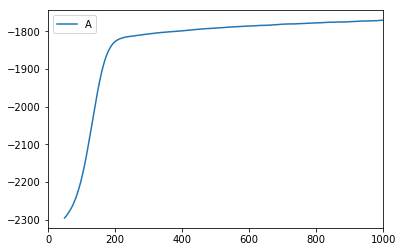

time: 170 ms


In [127]:
pd.rolling_mean(df, 50).plot()

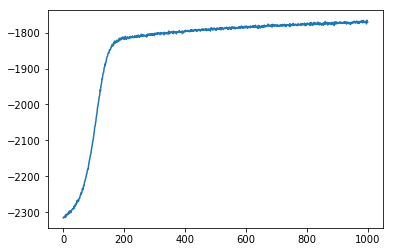

time: 142 ms


In [128]:
plt.plot(l_r)
plt.show()

In [141]:
exp.mean_dist

AttributeError: 'Experiment' object has no attribute 'mean_dist'

time: 6.53 ms


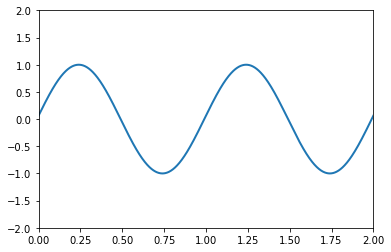

time: 8.38 s


In [180]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [208]:
[v[1] for v in exp.graphs["deep"]]

[[<tf.Tensor 'unrolled_model/unroll/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_1/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_2/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_3/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_4/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_5/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_6/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_7/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_8/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_9/add:0' shape=(2, 1024) dtype=float32>]]

time: 3.19 ms


/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=1).mean()
  from ipykernel import kernelapp as app


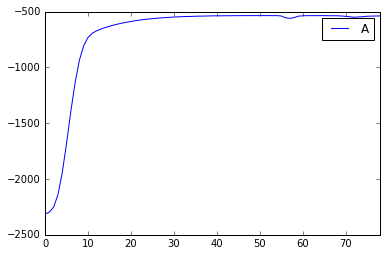

time: 3.66 s


In [121]:
d_loss = pd.DataFrame({"A":exp.list_rewards})
pd.rolling_mean(d_loss, 1).plot()

/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=1).mean()
  from ipykernel import kernelapp as app


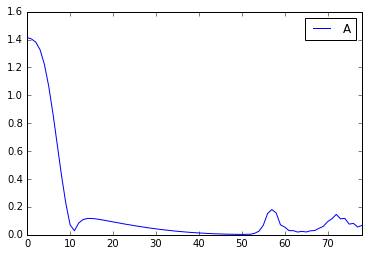

time: 1.52 s


In [122]:
d_distance = pd.DataFrame({"A":exp.list_distances})
pd.rolling_mean(d_distance, 1).plot()

In [123]:
x = [l[0] for l in exp.list_last_pos]
y = [l[1] for l in exp.list_last_pos]

time: 17.7 ms


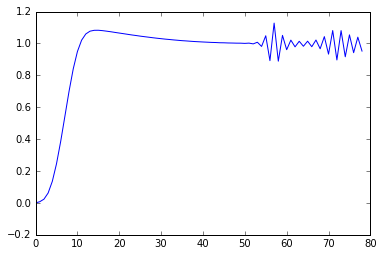

time: 1.04 s


In [124]:
plt.plot(x)
plt.show()

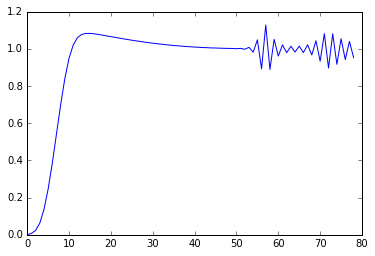

time: 738 ms


In [125]:
plt.plot(y)
plt.show()

In [51]:
y

[-2.2958116e-06,
 9.467356e-06,
 2.0522149e-05,
 3.1006573e-05,
 4.2094634e-05,
 5.3634874e-05,
 6.6518522e-05,
 7.987085e-05,
 9.5443305e-05,
 0.00011218048,
 0.00013123931,
 0.0001524719,
 0.00017628376,
 0.00020300706,
 0.00023276889,
 0.00026559035,
 0.00030192279,
 0.00034205173,
 0.00038596528,
 0.00043371142,
 0.00048528492,
 0.00054148689,
 0.00060065562,
 0.00066483958,
 0.00073214795,
 0.00080441998,
 0.00088042946,
 0.0009605505,
 0.0010433106,
 0.0011314519,
 0.001222854,
 0.0013180977,
 0.0014173938,
 0.0015198635,
 0.0016253334,
 0.0017352051,
 0.0018467359,
 0.0019630818,
 0.0020827164,
 0.0022053518,
 0.0023301085,
 0.0024585039,
 0.0025888646,
 0.0027235693,
 0.0028599428,
 0.0029990294,
 0.0031430982,
 0.0032881782,
 0.0034356799,
 0.0035857339,
 0.0037413605,
 0.0038924003,
 0.0040508187,
 0.0042106193,
 0.004371997,
 0.0045336252,
 0.0047002002,
 0.0048660953,
 0.0050310092,
 0.0051996829,
 0.0053723375,
 0.0055422643,
 0.0057098968,
 0.0058846292,
 0.0060534282,
 0

time: 28.3 ms


In [1]:
l = [3, 4, 5]
for i,j in enumerate(l):
    print(i,j)

0 3
1 4
2 5


In [53]:
d_distance

,A
0,1.414216
1,1.414200
2,1.414185
3,1.414169
4,1.414154
5,1.414137
6,1.414120
7,1.414099
8,1.414078
9,1.414056


time: 31.2 ms
